# Collecting data and labelling with cellpose

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
FOLDER_NAME = "2024.05.09. Ac-kPHSRN+fibronektin"

!unzip "/content/drive/MyDrive/{FOLDER_NAME}.zip" -d "/content"

In [ ]:
%pip install cellpose

In [ ]:
import numpy as np
import glob
import cv2
import torch
from cellpose import models

# Loading the images.
file_names = glob.glob(FOLDER_NAME + "/*.jpg")

imgs = []
for name in file_names:
  img = cv2.imread(name, 0) # grayscale
  imgs.append(img)

# Using cyto3 cellpose model to label the images.
model = models.CellposeModel(model_type="cyto3", gpu=torch.cuda.is_available())

channels = [0, 0] # grayscale
flow_threshold = 0.4
cellprob_threshold = 0.0

masks, _, _ = model.eval(imgs, channels=channels, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)

In [27]:
# Only using average pixel intensity through the whole image as feature.
x = np.array([np.mean(img) for img in imgs])
y = np.array([np.max(mask) for mask in masks])

# Creating train and test datasets.
split_id = int(0.85 * len(x))
x_train, y_train = x[:split_id], y[:split_id]
x_test, y_test = x[split_id:], y[split_id:]

print(f"Train data points: {len(x_train)}")
print(f"Test data points: {len(x_test)}")

Train data points: 40
Test data points: 8


# Linear regression based on average intensity

Average noise: 5.002220859751105e-12


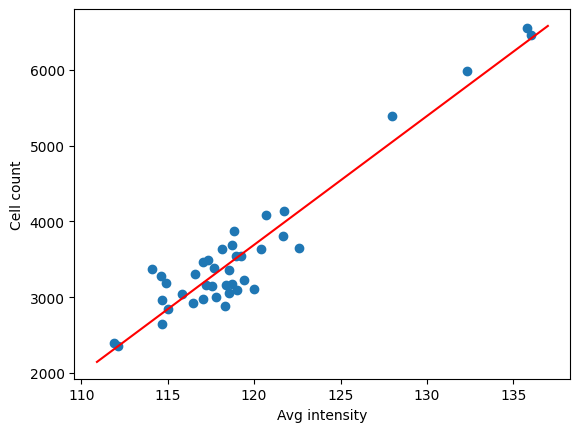

In [46]:
import matplotlib.pyplot as plt

# Linear regression to predict cell counts.
A = np.vstack([x_train, np.ones(len(x_train))]).T
m, c = np.linalg.lstsq(A, y_train, rcond=None)[0]

def f(x):
  return m * x + c

# Plotting the training data and results.
xs = np.arange(np.min(x_train)-1, np.max(x_train)+1, 0.1)
plt.xlabel("Avg intensity")
plt.ylabel("Cell count")
plt.scatter(x_train, y_train)
plt.plot(xs, f(xs), color="red");

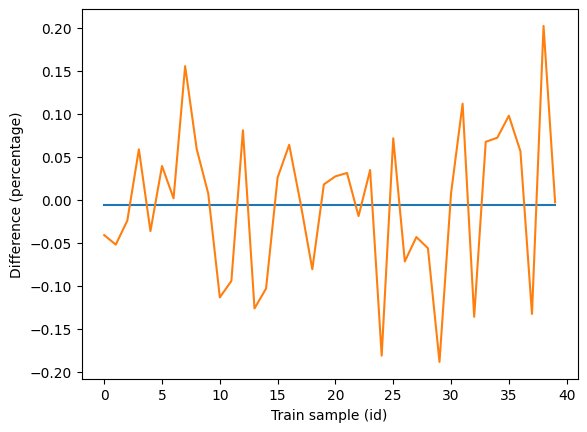

In [67]:
p_noise = (y_train - f(x_train)) / y_train
avg_p_noise = np.mean(p_noise)

plt.xlabel("Train sample (id)")
plt.ylabel("Difference (percentage)")
plt.plot([0, len(x_train)-1], [avg_p_noise, avg_p_noise])
plt.plot(np.arange(len(x_train)), p_noise);

In [97]:
mean_errors = (y_test - f(x_test)) ** 2
avg_mean_error = np.mean(mean_errors)
avg_deviation = np.mean(np.abs(y_test - f(x_test)))
print(f"Mean squared error on test dataset: {avg_mean_error}")
print(f"Average deviation: {avg_deviation}")

Mean squared error on test dataset: 73628.79359537642
Average deviation: 227.84943458918406


Worst mean error: 244665.62693635782
Actual: 2950, predicted: 3444.636863705444


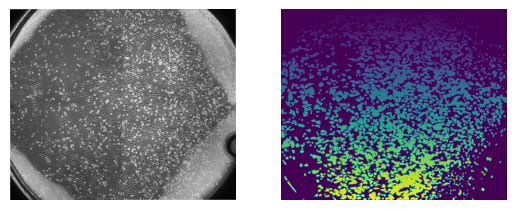

In [98]:
worst_id = split_id + np.argmax(mean_errors)

print(f"Worst mean error: {np.max(mean_errors)}")
print(f"Actual: {y[worst_id]}, predicted: {f(x[worst_id])}")

plt.subplot(121)
plt.axis("off")
plt.imshow(imgs[worst_id], cmap="gray")

plt.subplot(122)
plt.axis("off")
plt.imshow(masks[worst_id]);